In [2]:
# import numpy as np
# import matplotlib.pyplot as plt
# import sionna
# import scipy
# from mpl_toolkits.mplot3d import Axes3D

import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna==0.19")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 40

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

from sionna import PI
from sionna.rt import load_scene, Transmitter, Receiver, RIS, PlanarArray, \
                      r_hat, normalize, Camera

In [3]:
# Load an empty scene and configure single linearly polarized antennas for
# all transmitters and receivers
scene = load_scene()
scene.frequency = 3e9 # Carrier frequency [Hz]
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")
scene.rx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")

# Place a transmitter far away from the RIS so that
# the incoming wave is almost planar
tx = Transmitter("tx", [0,0,500])
scene.add(tx)

# Configure RIS in the x-z plane centered at the origin
width = 7 # Width [m] as described in [1]
num_rows = num_cols = int(width/(0.5*scene.wavelength))
ris = RIS(name="ris",
          position=[0,0,0],
          orientation=[0,-PI/2,0],
          num_rows=num_rows,
          num_cols=num_cols)
scene.add(ris)

In [4]:
print("RIS size (width, height) [m]: ", ris.size.numpy())
print("Number of cells: ", ris.num_cells)
print("Velocity vector [m/s]: ", ris.velocity.numpy())
print(ris.amplitude_profile.values)
print(ris.phase_profile.values)

RIS size (width, height) [m]:  [6.9951577 6.9951577]
Number of cells:  19600
Velocity vector [m/s]:  [0. 0. 0.]
tf.Tensor(
[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]], shape=(1, 140, 140), dtype=float32)
tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]], shape=(1, 140, 140), dtype=float32)


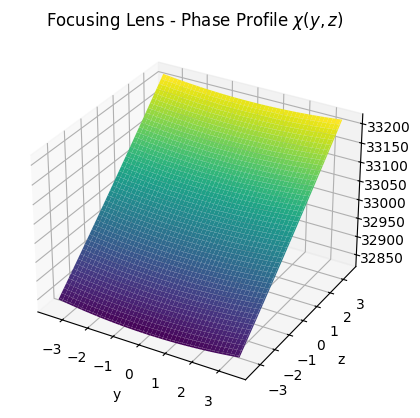

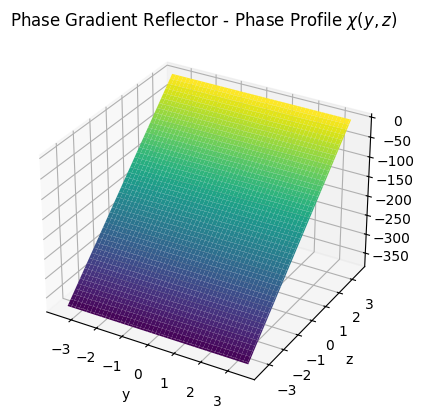

In [5]:
source = tx.position # Location of the origin of the incoming ray
target = 25.*r_hat(PI/3, 0.) # Target position

# Configure the RIS as focusing lens
ris.focusing_lens(source, target)

# Visualize the phase profile
ris.phase_profile.show();
plt.title(r"Focusing Lens - Phase Profile $\chi(y,z)$");

# Configure the RIS as phase gradient reflector
# Source and target vectors are automatically nornmalized
# in this function as only the directions matter
ris.phase_gradient_reflector(source, target)

# Visualize the phase profile
ris.phase_profile.show();
plt.title(r"Phase Gradient Reflector - Phase Profile $\chi(y,z)$");


Text(0, 0.5, 'z (m)')

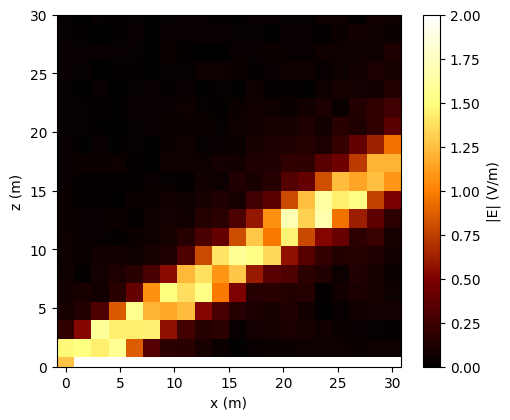

In [10]:
# ris.focusing_lens(source, target) # Uncomment to change the RIS configuration

# Define a grid of points in the x-z plane
x_min = 0
x_max = 30
num_steps = 20 # Increase to obtain a finer resolution
x = tf.cast(tf.linspace(x_min, x_max, num_steps), tf.float32)
x_grid, z_grid = tf.meshgrid(x, x)
x = tf.reshape(x_grid, [-1])
z = tf.reshape(z_grid, [-1])
y = tf.zeros_like(x)
r = tf.stack([x, y, z], -1)

def field_at_points(scene, r, batch_size, path_loss=False):
    """
    Compute absolute field strength at a list of positions

    Input
    -----
    r : [num_points, 3]
        Points at which the field should be computed

    batch_size : int
        Since we cannot compute the field at all points
        simultaneously, we need to batch the computations.
        Must divide `num_points` without rest.

    path_loss : bool
        If `True`, the path loss in dB is returned and not the
        absolte field strength.

    Output
    ------
    e : [num_points]
        Absolute value of field strength
    """
    # Add batch_size receivers to the scene
    # if they do not already exist
    if len(scene.receivers)==0:
        for i in range(batch_size):
            scene.add(Receiver(f"rx-{i}", [0,0,0]))

    # Iteratively compute field for all positions
    r_vec = tf.reshape(r, [-1, batch_size, 3])
    em = tf.zeros([0], tf.float32)
    for j, rs in enumerate(r_vec):

        # Move receivers to new positions
        for i,r in enumerate(rs):
            scene.get(f"rx-{i}").position=r

        # Compute paths and obtain channel impulse responses
        paths = scene.compute_paths(los=False, reflection=False, ris=True)
        a = tf.squeeze(paths.cir()[0])

        # We need to scale the path gain by the distance from the
        # transmitter to the RIS to simulate an incoming field stength of
        # 1 V/m and undo the effect of the isotropic antenna
        # see https://jhoydis.github.io/sionna-0.19.2-doc/em_primer.html#equation-h-final
        if path_loss:
            e = 20*tf.math.log(tf.abs(a))/tf.math.log(10.)
        else:
            e = 4*PI/scene.wavelength*normalize(tx.position)[1]*tf.abs(a)
        em = tf.concat([em, e], axis=0)
    return em

em = field_at_points(scene, r, 40)
em = tf.reshape(em, x_grid.shape)

# Visualize the field
plt.figure(figsize=(5.55, 4.57))
plt.pcolormesh(x_grid, z_grid, em, cmap='afmhot', vmin=0, vmax=2)
plt.ylim([0, 30])
cb = plt.colorbar()
cb.set_label(r"|E| (V/m)")
plt.xlabel("x (m)")
plt.ylabel("z (m)")

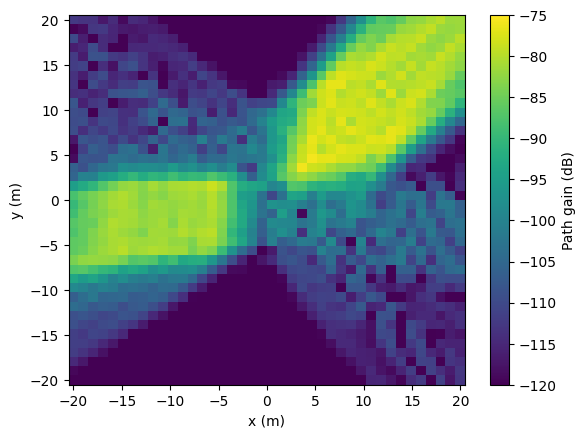

In [11]:
# Load empty scene
scene = load_scene()
scene.frequency = 3e9 # Carrier frequency [Hz]
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")
scene.rx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")

# Place a transmitter
tx = Transmitter("tx", [0,0,50])
scene.add(tx)

# Configure RIS in the x-z plane centered at the origin
# Note that we need to configure `num_modes=2` here.
width = 7 # Width [m]
num_rows = num_cols = int(width/(0.5*scene.wavelength))
ris = RIS(name="ris",
              position=[0,0,0],
              orientation=[0,-PI/2,0],
              num_rows=num_rows,
              num_cols=num_cols,
              num_modes=2)
scene.add(ris)

# Configure the RIS with two reradiation modes
# Each reradiation mode is defined by a pair of source and target vectors
z_target = 5
sources = [tx.position, tx.position]
targets = [[10, 10, z_target], [-10, -2, z_target]]
ris.phase_gradient_reflector(sources, targets)

# Uncomment to observe the difference when a focusing lens is used.
# ris.focusing_lens(sources, targets)

# You can freely distribute power among the modes
ris.amplitude_profile.mode_powers = [0.7, 0.3]

# Define a grid of points in the x-y plane at some height
x_min = -20
x_max = 20
num_steps = 40 # Increase to obtain a finer resolution
x = tf.cast(tf.linspace(x_min, x_max, num_steps), tf.float32)
x_grid, y_grid = tf.meshgrid(x, x)
x = tf.reshape(x_grid, [-1])
y = tf.reshape(y_grid, [-1])
z = z_target*tf.ones_like(x)
r = tf.stack([x, y, z], -1)

# Compute path loss
pl = field_at_points(scene, r, 40, path_loss=True)
pl = tf.reshape(pl, x_grid.shape)

# Visualize the field
plt.figure()
plt.pcolormesh(x_grid, y_grid, pl, vmax=-75, vmin=-120)
cb = plt.colorbar()
cb.set_label(r"Path gain (dB)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")

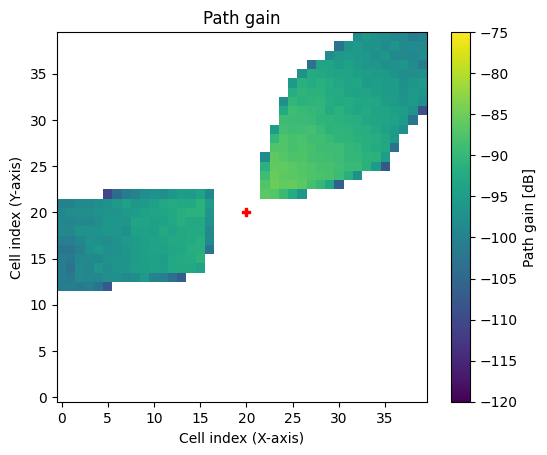

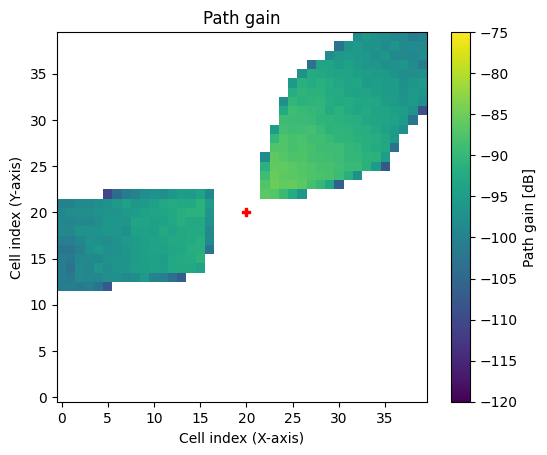

In [12]:
cm = scene.coverage_map(los=False, # Disable LOS for better visualization of the RIS field
                        num_samples=10e6,
                        cm_orientation=[0,0,0],
                        cm_center=[0,0,z_target],
                        cm_size=[40,40],
                        cm_cell_size=[1, 1])
cm.show(vmin=-120, vmax=-75)

/tmp/ipykernel_10465/2743490507.py:58: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10*np.log10(cm_ris.path_gain[0]/cm_no_ris.path_gain[0]), origin='lower', vmin=0)


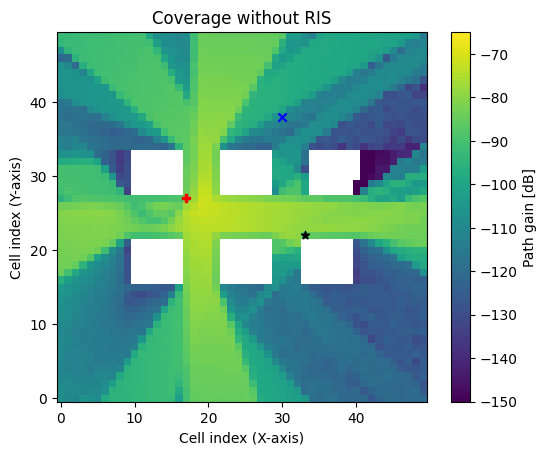

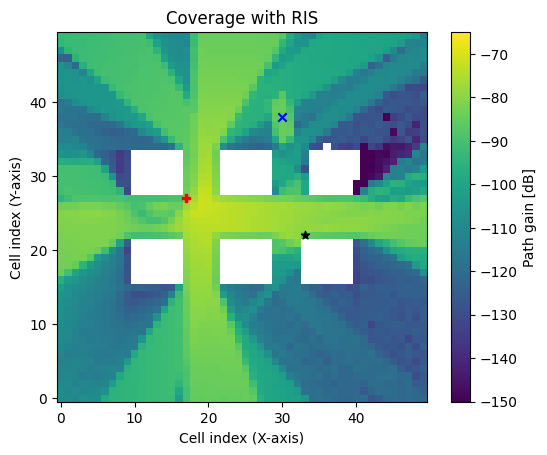

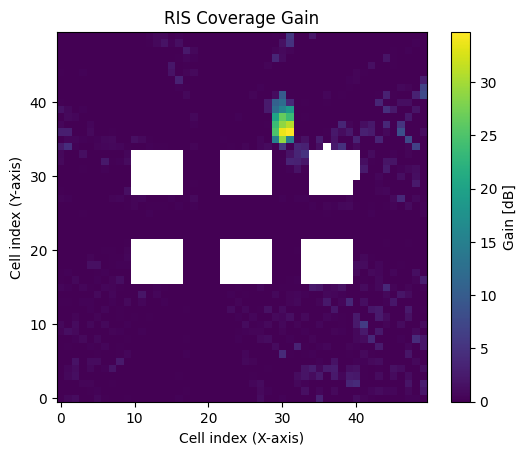

In [13]:
scene = load_scene(sionna.rt.scene.simple_street_canyon)
scene.frequency = 3e9 # Carrier frequency [Hz]
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")
scene.rx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")

# Place a transmitter
tx = Transmitter("tx", position=[-32,10,32], look_at=[0,0,0])
scene.add(tx)

# Place a receiver (we will not actually use it
# for anything apart from referencing the position)
rx = Receiver("rx", position=[22,52,1.7])
scene.add(rx)

# Place RIS
ris = RIS(name="ris",
          position=[32,-9,32],
          num_rows=100,
          num_cols=100,
          num_modes=1,
          look_at=(tx.position+rx.position)/2) # Look in between TX and RX
scene.add(ris)

# Configure RIS as phase gradient reflector that reradiates energy
# toward the direction of the receivers
ris.phase_gradient_reflector(tx.position, rx.position)

# Compute coverage map without RIS
cm_no_ris = scene.coverage_map(num_samples=2e6, #increase for better resolution
                        max_depth=5,
                        los=True,
                        reflection=True,
                        diffraction=True,
                        ris=False,
                        cm_cell_size=[4,4],
                        cm_orientation=[0,0,0],
                        cm_center=[0,0,1.5],
                        cm_size=[200,200])
cm_no_ris.show(vmax=-65, vmin=-150, show_ris=True, show_rx=True)
plt.title("Coverage without RIS")

# Compute coverage map with RIS
cm_ris = scene.coverage_map(num_samples=2e6, #increase for better resolution
                        max_depth=5,
                        los=True,
                        reflection=True,
                        diffraction=True,
                        ris=True,
                        cm_cell_size=[4,4],
                        cm_orientation=[0,0,0],
                        cm_center=[0,0,1.5],
                        cm_size=[200,200])
cm_ris.show(vmax=-65, vmin=-150, show_ris=True, show_rx=True)
plt.title("Coverage with RIS")

# Visualize the coverage improvements thanks to the RIS
fig = plt.figure()
plt.imshow(10*np.log10(cm_ris.path_gain[0]/cm_no_ris.path_gain[0]), origin='lower', vmin=0)
plt.colorbar(label='Gain [dB]')
plt.xlabel('Cell index (X-axis)')
plt.ylabel('Cell index (Y-axis)')
plt.title("RIS Coverage Gain")